# Effectiveness prediction

In [1]:
import pandas as pd
import json
import random
import numpy as np

In [2]:
creative_data = pd.read_csv('./data/creative_data_v2.csv')

In [3]:
creative_data.head()

,creative_id,no_of_days,impressions,clicks,media_cost_usd,campaign_counts,no_of_days_min,impressions_min,clicks_min,no_of_days_max,...,Video_days,Display_fraction,Mobile_fraction,Search_fraction,Social_fraction,Video_fraction,country,ctir,effectiveness_category,mean_media_cost
0,1000,45,9471,152,405.311290,5,7,837,8,11,...,10,0.000000,0.400000,0.000000,0.377778,0.222222,Singapore,1.604899,above_med,81.062258
1,1005,5643,52011,638,805.049336,66,53,524,2,118,...,732,0.219032,0.165869,0.339004,0.146376,0.129718,US,1.226664,below_med,12.197717
2,1010,5643,38026,519,405.672070,66,53,514,2,118,...,1100,0.144250,0.239943,0.209463,0.211412,0.194932,US,1.364856,above_med,6.146547
3,1015,5643,48051,629,964.308318,66,53,546,2,118,...,1181,0.120858,0.144604,0.251108,0.274145,0.209286,US,1.309026,below_med,14.610732
4,1020,5643,38519,512,414.202772,66,53,514,3,118,...,1091,0.212298,0.223285,0.196527,0.174553,0.193337,US,1.329214,above_med,6.275800


## Classical image features

In [4]:
creative_features = pd.read_csv('./data/features/classical_creative_features.csv')

In [5]:
creative_features.head()

,creative_id,aspect_ratio,color,read_mean,green_mean,blue_mean,red_std,green_std,blue_std,brightness,...,blue_dom_color7,weight_dom_color7,red_dom_color8,green_dom_color8,blue_dom_color8,weight_dom_color8,red_dom_color9,green_dom_color9,blue_dom_color9,weight_dom_color9
0,1000,0.667188,1,0.199123,0.271816,0.371865,48.531470,36.073478,46.842777,0.261469,...,0.143347,0.031971,0.030897,0.375683,0.673309,0.043699,0.452279,0.529923,0.590956,0.044855
1,10000,1.319736,1,0.779949,0.779218,0.777672,56.022431,56.278342,56.366826,0.779306,...,0.555901,0.032253,0.606414,0.605481,0.600985,0.038587,0.382069,0.380722,0.376519,0.042227
2,10005,0.772727,0,0.145030,0.145030,0.145030,85.944494,85.944494,85.944494,0.145030,...,0.721242,0.002160,0.322807,0.322807,0.322807,0.002211,0.659941,0.659941,0.659941,0.002298
3,10010,1.777778,1,0.943396,0.369360,0.401235,44.115418,95.586132,85.899619,0.544297,...,0.534784,0.001066,0.566190,0.378674,0.322565,0.001541,0.505679,0.089081,0.061342,0.001569
4,10015,0.706250,1,0.628284,0.486499,0.436248,31.831054,36.820207,34.461763,0.523478,...,0.271857,0.014137,0.280988,0.152431,0.116449,0.015404,0.979414,0.748960,0.623834,0.016077


In [6]:
creative_data = pd.merge(creative_data, creative_features, on='creative_id')

In [7]:
creative_data.columns

Index(['creative_id', 'no_of_days', 'impressions', 'clicks', 'media_cost_usd',
       'campaign_counts', 'no_of_days_min', 'impressions_min', 'clicks_min',
       'no_of_days_max', 'impressions_max', 'clicks_max', 'no_of_week_days',
       'no_of_week_end', 'fraction_week_days', 'fraction_week_end',
       'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
       'Video_days', 'Display_fraction', 'Mobile_fraction', 'Search_fraction',
       'Social_fraction', 'Video_fraction', 'country', 'ctir',
       'effectiveness_category', 'mean_media_cost', 'aspect_ratio', 'color',
       'read_mean', 'green_mean', 'blue_mean', 'red_std', 'green_std',
       'blue_std', 'brightness', 'contrast', 'entropy', 'warm_fraction',
       'cool_fraction', 'saturation_mean', 'red_dom_color0',
       'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
       'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
       'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
       'bl

In [8]:
#split train/test

random.seed(42)
list_creative_ids = list(creative_data.index)
random.shuffle(list_creative_ids)

train_test_split_index = int(len(list_creative_ids) * 0.8)
creative_ids_train = list_creative_ids[:train_test_split_index]
creative_ids_test = list_creative_ids[train_test_split_index:]

train_data = creative_data.loc[creative_ids_train]
test_data = creative_data.loc[creative_ids_test]


Rather than regression of the metric we chose for effectiveness (CTIR), we are probably more interested in classification, or being able to predict if a creative will be effective or not. We defined already a category for this based on the CTIR. The thresholds were a bit arbritary, based on percentiles per country, but will be good enough for this exercise.

In [9]:
train_data.effectiveness_category.value_counts() / len(train_data)

effectiveness_category
below_med      0.496791
above_med      0.297818
good           0.154899
exceptional    0.050492
Name: count, dtype: float64

In [10]:
test_data.effectiveness_category.value_counts() / len(test_data)

effectiveness_category
below_med      0.509402
above_med      0.307692
good           0.129915
exceptional    0.052991
Name: count, dtype: float64

Thanks to the random split, the statistics of the category are practically equal between train and test datasets.
Let us reduce further the categories first and group together below and above med as 0 and good and exceptional as 1 for a binary class, which will be the target, "effective"

In [11]:
# train_data['effective'] = train_data.effectiveness_category.isin(['good', 'exceptional']).astype(int)
# test_data['effective'] = test_data.effectiveness_category.isin(['good', 'exceptional']).astype(int)
creative_data['effective'] = creative_data.effectiveness_category.isin(['good', 'exceptional']).astype(int)
creative_data['very_effective'] = creative_data.effectiveness_category.isin(['exceptional']).astype(int)
train_data = creative_data.loc[creative_ids_train].reset_index(drop=True)
test_data = creative_data.loc[creative_ids_test].reset_index(drop=True)

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [13]:
from cemodel import CreativeEffectivenessModel

Let's try first a LGBM model trained over creative data and classical features. We are adding first weekend/weekday fraction and channel fraction. Even if we created this normalized features in order to hide the total number of days, they can still leak information since the way the campaigns were distributed along time can depend on the performance. Same happens with the media cost. The average hides the actual number of campaigns but if the cost depends on the decisions taken during the use of the creative in different campaigns, it is not a valid feature since it depends on the effectiveness itself.

In [14]:
features = [ 
    'mean_media_cost', 'fraction_week_days', 'fraction_week_end',
       'Display_fraction', 'Mobile_fraction', 'Search_fraction',
       'Social_fraction', 'Video_fraction', 
            'country',
       'aspect_ratio', 'color', 'read_mean',
       'green_mean', 'blue_mean', 'red_std', 'green_std', 'blue_std',
       'brightness', 'contrast', 'entropy', 'warm_fraction', 'cool_fraction',
       'saturation_mean', 'red_dom_color0', 'green_dom_color0',
       'blue_dom_color0', 'weight_dom_color0', 'red_dom_color1',
       'green_dom_color1', 'blue_dom_color1', 'weight_dom_color1',
       'red_dom_color2', 'green_dom_color2', 'blue_dom_color2',
       'weight_dom_color2', 'red_dom_color3', 'green_dom_color3',
       'blue_dom_color3', 'weight_dom_color3', 'red_dom_color4',
       'green_dom_color4', 'blue_dom_color4', 'weight_dom_color4',
       'red_dom_color5', 'green_dom_color5', 'blue_dom_color5',
       'weight_dom_color5', 'red_dom_color6', 'green_dom_color6',
       'blue_dom_color6', 'weight_dom_color6', 'red_dom_color7',
       'green_dom_color7', 'blue_dom_color7', 'weight_dom_color7',
       'red_dom_color8', 'green_dom_color8', 'blue_dom_color8',
       'weight_dom_color8', 'red_dom_color9', 'green_dom_color9',
       'blue_dom_color9', 'weight_dom_color9']
target = 'effective'
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.86
ROC AUC: 0.91
Precision: 0.62
Recall: 0.626
F1 Score: 0.623


The model actually behaves fairly well with these features. If we have a look at feature importance..

<Axes: >

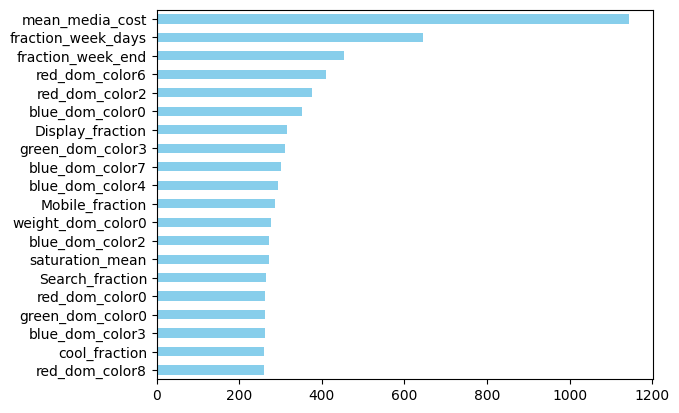

In [15]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')
top_features = importance_df.sort_values(ascending=False).head(20).sort_values()
top_features.plot.barh(color='skyblue')

we see that, as suspected, media cost and weekday/weekend fraction come first. This should be confirmed, but a priori we have to assume that these two features introduce leakage and are not valid predictors. Let's see how the performance drops without them

In [16]:
features = [ 
            'country',
       'aspect_ratio', 'color', 'read_mean',
       'green_mean', 'blue_mean', 'red_std', 'green_std', 'blue_std',
       'brightness', 'contrast', 'entropy', 'warm_fraction', 'cool_fraction',
       'saturation_mean', 'red_dom_color0', 'green_dom_color0',
       'blue_dom_color0', 'weight_dom_color0', 'red_dom_color1',
       'green_dom_color1', 'blue_dom_color1', 'weight_dom_color1',
       'red_dom_color2', 'green_dom_color2', 'blue_dom_color2',
       'weight_dom_color2', 'red_dom_color3', 'green_dom_color3',
       'blue_dom_color3', 'weight_dom_color3', 'red_dom_color4',
       'green_dom_color4', 'blue_dom_color4', 'weight_dom_color4',
       'red_dom_color5', 'green_dom_color5', 'blue_dom_color5',
       'weight_dom_color5', 'red_dom_color6', 'green_dom_color6',
       'blue_dom_color6', 'weight_dom_color6', 'red_dom_color7',
       'green_dom_color7', 'blue_dom_color7', 'weight_dom_color7',
       'red_dom_color8', 'green_dom_color8', 'blue_dom_color8',
       'weight_dom_color8', 'red_dom_color9', 'green_dom_color9',
       'blue_dom_color9', 'weight_dom_color9']
target = 'effective'
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.76
ROC AUC: 0.45
Precision: 0.13
Recall: 0.056
F1 Score: 0.078


Unfortunately, quite dramatic (another good indicator that the previous features depend on the effectiveness).

<Axes: >

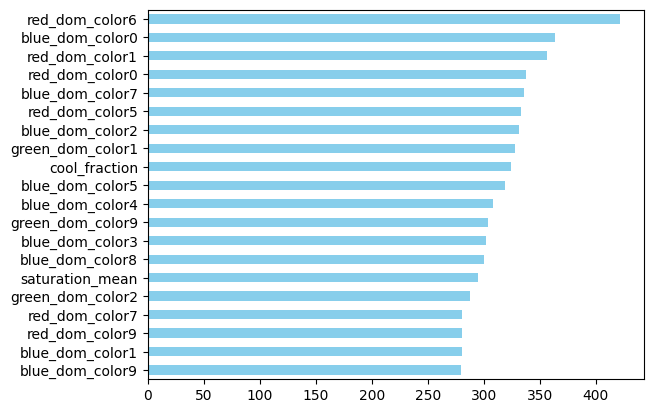

In [17]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')
top_features = importance_df.sort_values(ascending=False).head(20).sort_values()
top_features.plot.barh(color='skyblue')

The importance is quite uniform for many features. The fact that the ordering of the color components is quite random is an indicator that they are not actually very strong predictors.

In [18]:
# from sklearn.calibration import calibration_curve
# y_pred, y_pred_proba = cem.predict(test_data)
# prob_true, prob_pred = calibration_curve(test_data[target], y_pred_proba, n_bins=8)
# pd.Series(index = prob_pred, data=prob_true, name='true probability').plot()

In [19]:
cem = CreativeEffectivenessModel('nb', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.72
ROC AUC: 0.48
Precision: 0.14
Recall: 0.103
F1 Score: 0.118


A naive Bayes classifier does better in some metrics. And if we compare with other naive benchmarks, we can see that we are doing worse in most cases and metrics.

In [21]:
# Predict randomly with balanced probability
y_test = test_data[target]
y_random = np.random.randint(0, 2, size=len(y_test))
accuracy = accuracy_score(y_test, y_random)
roc_auc = roc_auc_score(y_test, y_random) 
precision = precision_score(y_test, y_random)
recall = recall_score(y_test, y_random)
f1 = f1_score(y_test, y_random)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5026
ROC AUC: 0.4889
Precision: 0.1761
Recall: 0.4673
F1 Score: 0.2558


In [23]:
# Predict randomly with observed target distribution
y_train = train_data[target]
prob_1 = y_train.mean()  # Probability of class 1
y_random = np.random.choice([0, 1], size=len(y_test), p=[1 - prob_1, prob_1])
accuracy = accuracy_score(y_test, y_random)
roc_auc = roc_auc_score(y_test, y_random) 
precision = precision_score(y_test, y_random)
recall = recall_score(y_test, y_random)
f1 = f1_score(y_test, y_random)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6855
ROC AUC: 0.5138
Precision: 0.2016
Recall: 0.2430
F1 Score: 0.2203


In [24]:
# Predict always 0 (not effective):
# produces and accuracy = prob_0 =
1 - prob_1 
# Area over ROC is 0.5 since it's a y = x line and the rest of metrics are 0 (we are not guessing any effective creative right)

np.float64(0.7946084724005135)

In [25]:
# similar performance for some other kind of NN classifier models
cem = CreativeEffectivenessModel('nn2', features, target)
cem_error = cem.train_eval(train_data, test_data, verbose=False)
pd.Series(cem_error).round(3)

accuracy     0.721
roc_auc      0.465
precision    0.122
recall       0.084
f1           0.099
dtype: float64

## Using modern feat

### Vision foundation model

In [26]:
with open('data/features/output_features_gvlab_vit6b.json', 'r') as jfile:
    dict_features = json.load(jfile)

In [27]:
vit_features = pd.DataFrame(pd.Series(dict_features).rename('vit_array'))
vit_features.index.name = 'creative_id'
vit_features.reset_index(inplace=True)
vit_features_columns = [f'vit_{i}' for i in range(len(vit_features['vit_array'][0]))]
df_vit = pd.DataFrame(vit_features['vit_array'].tolist(), columns=vit_features_columns)

vit_features = pd.concat([vit_features, df_vit], axis=1)

vit_features.drop(columns=['vit_array'], inplace=True)
vit_features.creative_id = vit_features.creative_id.astype(int)
vit_features.head()

,creative_id,vit_0,vit_1,vit_2,vit_3,vit_4,vit_5,vit_6,vit_7,vit_8,...,vit_3190,vit_3191,vit_3192,vit_3193,vit_3194,vit_3195,vit_3196,vit_3197,vit_3198,vit_3199
0,10120,-0.578125,0.138672,0.042969,1.546875,2.234375,-0.246094,0.253906,-0.324219,-3.234375,...,-3.125000,2.359375,-1.171875,1.046875,0.800781,2.562500,-0.166992,-0.244141,0.878906,-0.134766
1,10085,-0.769531,-1.945312,1.109375,-0.285156,0.441406,-0.498047,-1.304688,0.718750,-1.648438,...,-4.343750,1.031250,-0.875000,1.523438,0.406250,-0.131836,0.137695,-0.742188,0.120117,-0.072266
2,10060,-0.941406,-2.359375,1.546875,1.281250,-1.632812,1.804688,-0.765625,1.265625,-3.812500,...,-1.070312,1.734375,0.281250,0.492188,1.171875,-0.100586,2.703125,0.012695,0.550781,-2.031250
3,10075,-0.746094,-1.046875,1.234375,-1.117188,1.125000,-0.289062,-1.687500,2.375000,-1.570312,...,-3.671875,1.789062,-0.312500,-0.652344,-0.757812,1.007812,0.021362,0.316406,0.196289,-2.515625
4,10055,-0.800781,-1.843750,0.679688,-0.621094,-1.562500,1.515625,-1.546875,0.585938,-1.343750,...,-4.593750,1.390625,0.082031,0.277344,-0.921875,1.460938,1.601562,-0.114746,0.917969,-0.875000


In [28]:
creative_data_vit = pd.merge(creative_data, vit_features, on='creative_id')
creative_data_vit.head()

,creative_id,no_of_days,impressions,clicks,media_cost_usd,campaign_counts,no_of_days_min,impressions_min,clicks_min,no_of_days_max,...,vit_3190,vit_3191,vit_3192,vit_3193,vit_3194,vit_3195,vit_3196,vit_3197,vit_3198,vit_3199
0,1000,45,9471,152,405.311290,5,7,837,8,11,...,-3.421875,1.593750,-0.765625,0.941406,-0.835938,-0.257812,-0.027588,-0.277344,0.738281,-0.115234
1,1005,5643,52011,638,805.049336,66,53,524,2,118,...,-5.312500,2.078125,0.320312,0.710938,1.695312,1.250000,-0.240234,-1.390625,1.648438,-0.960938
2,1010,5643,38026,519,405.672070,66,53,514,2,118,...,-0.765625,2.265625,0.068359,0.820312,2.031250,0.960938,0.476562,-0.980469,1.039062,-0.308594
3,1015,5643,48051,629,964.308318,66,53,546,2,118,...,-4.375000,1.484375,1.796875,1.296875,-0.722656,0.204102,-0.890625,-2.218750,1.625000,-0.503906
4,1020,5643,38519,512,414.202772,66,53,514,3,118,...,-3.671875,0.933594,0.058594,1.117188,-0.738281,0.455078,0.242188,-0.808594,0.808594,-0.968750


In [29]:
train_data = creative_data_vit.loc[creative_ids_train].reset_index(drop=True)
test_data = creative_data_vit.loc[creative_ids_test].reset_index(drop=True)

We will all the features from the vision model (3200!). These are two many considering the size of the dataset (under 3000 creatives), but let's give it a try

In [30]:
features = [
       'country', 'aspect_ratio',
        'color', 'read_mean', 'green_mean', 'blue_mean',
       'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
       'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
       'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
       'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
       'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
       'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
       'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
       'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
       'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
       'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
       'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
       'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
       'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
       'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
       'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
features += vit_features_columns
target = 'effective'
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.78
ROC AUC: 0.48
Precision: 0.17
Recall: 0.056
F1 Score: 0.084


Very slight improvement and still worse than naive predicions. Notice that we can modulate some metrics by adjusting the decision threshold of the classifier

In [31]:
_ = cem.eval(test_data, threshold=0.7)

Accuracy: 0.78
ROC AUC: 0.48
Precision: 0.19
Recall: 0.056
F1 Score: 0.086


In [32]:
_ = cem.eval(test_data, threshold=0.3)

Accuracy: 0.76
ROC AUC: 0.48
Precision: 0.14
Recall: 0.056
F1 Score: 0.080


but since the ROC is so bad there is no much sensitivity. No change either if we drop all the classical image processing features:

In [33]:
features = [
       'country', 'aspect_ratio'
    ]
features += vit_features_columns
target = 'effective'
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.78
ROC AUC: 0.47
Precision: 0.19
Recall: 0.065
F1 Score: 0.098


<Axes: >

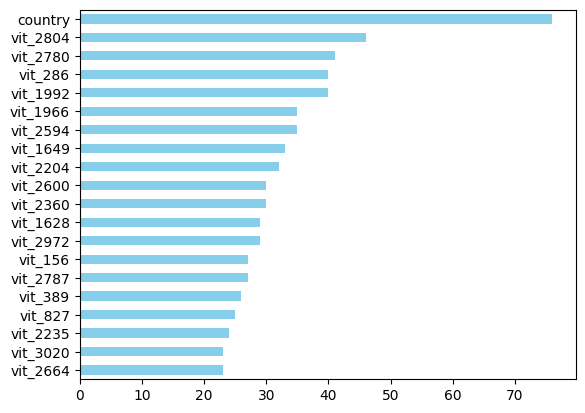

In [34]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')
top_features = importance_df.sort_values(ascending=False).head(20).sort_values()
top_features.plot.barh(color='skyblue')

Notice that country is the most importance feature according to the trained lgbm model, but it did not even appear on the top when using the classical image features. Another sign that the model is not learning (or learning noise that overfits the training data. We could have set actually a validation dataset out from the training to perform early stopping but seeing the result it's probably not worth bothering. We actually already tried reducing the number of predictor trees, which has the same effect)

Similar behavior for a NN with 2 linear hidden layers (better in some metrics but still under naive baselines).

In [35]:
cem = CreativeEffectivenessModel('nn2', features, target)
cem_error = cem.train_eval(train_data, test_data, verbose=False)
pd.Series(cem_error).round(3)

accuracy     0.725
roc_auc      0.462
precision    0.171
recall       0.131
f1           0.148
dtype: float64

Let's try to reduce the dimensions of the Vit model features previous to training the classifier. We will use PCA algorithms and also kmeans clustering.

In [37]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA, KernelPCA
from scipy.special import softmax

In [38]:
dim_red_method = 'kmeans'#'kpca' #'pca'
dimensions = 100
normalizer = Normalizer(norm='l2')
if dim_red_method == 'kpca':
    cluster_vit = KernelPCA(n_components=dimensions, kernel='sigmoid')#
elif dim_red_method == 'kmeans':
    cluster_vit = KMeans(n_clusters=dimensions)
elif dim_red_method == 'pca':
    cluster_vit = PCA(n_components=dimensions)#
vit_train_data_normalized = normalizer.fit_transform(train_data[vit_features_columns]) #train_data[vit_features_columns]#
vit_test_data_normalized = normalizer.transform(test_data[vit_features_columns]) #test_data[vit_features_columns]#

cluster_vit.fit(vit_train_data_normalized)

KMeans(n_clusters=100)

In [40]:
if dim_red_method in [ 'pca', 'kpca']:
    trans_feat_train = cluster_vit.transform(vit_train_data_normalized)#train_data[vit_features_columns])
    trans_feat_test = cluster_vit.transform(vit_test_data_normalized)#test_data[vit_features_columns])
elif dim_red_method == 'kmeans':
    #features in this case will be a 'kind of' probability of belonging to a cluster based on distance to centroids
    dist_train = cluster_vit.transform(vit_train_data_normalized)
    dist_test = cluster_vit.transform(vit_test_data_normalized)
    trans_feat_train = softmax(-dist_train, axis=1)
    trans_feat_test = softmax(-dist_test, axis=1)

In [41]:
trans_vit_columns = [f'trans_{i}' for i in range(trans_feat_train.shape[1])]
train_data_trans = pd.concat((train_data, 
                        pd.DataFrame(trans_feat_train, columns=trans_vit_columns)),
                       axis=1)
test_data_trans = pd.concat((test_data, 
                        pd.DataFrame(trans_feat_test, columns=trans_vit_columns)),
                       axis=1)

In [42]:
features = [
       'country', 'aspect_ratio',
       #  'color', 'read_mean', 'green_mean', 'blue_mean',
       # 'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
       # 'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
       # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
       # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
       # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
       # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
       # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
       # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
       # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
       # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
       # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
       # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
       # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
       # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
       # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
features += trans_vit_columns
target = 'effective'
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data_trans, test_data_trans)

Accuracy: 0.76
ROC AUC: 0.53
Precision: 0.17
Recall: 0.084
F1 Score: 0.112


It turns out we are doing worse, regardless of the reduction method. We are not capturing meaningful features from the image description.

In [43]:
cem = CreativeEffectivenessModel('nn2', features, target)
cem_error = cem.train_eval(train_data_trans, test_data_trans, verbose=False)
pd.Series(cem_error).round(3)

accuracy     0.745
roc_auc      0.532
precision    0.244
recall       0.187
f1           0.212
dtype: float64

### Image classification model embeddings

In [44]:
with open('data/features/output_features_dinov2.json', 'r') as jfile:
    dict_features = json.load(jfile)

In [45]:
vit_features2 = pd.DataFrame(pd.Series(dict_features).rename('vit_array'))
vit_features2.index.name = 'creative_id'
vit_features2.reset_index(inplace=True)
vit_features2_columns = [f'vit2_{i}' for i in range(len(vit_features2['vit_array'][0]))]
df_vit = pd.DataFrame(vit_features2['vit_array'].tolist(), columns=vit_features2_columns)

vit_features2 = pd.concat([vit_features2, df_vit], axis=1)

vit_features2.drop(columns=['vit_array'], inplace=True)
vit_features2.creative_id = vit_features2.creative_id.astype(int)
vit_features2.head()

,creative_id,vit2_0,vit2_1,vit2_2,vit2_3,vit2_4,vit2_5,vit2_6,vit2_7,vit2_8,...,vit2_1014,vit2_1015,vit2_1016,vit2_1017,vit2_1018,vit2_1019,vit2_1020,vit2_1021,vit2_1022,vit2_1023
0,6530,0.624470,-1.101754,0.000121,-1.064858,0.065610,2.169576,2.382757,2.472283,-1.933884,...,0.428459,-0.170853,-0.997335,0.738035,-2.520880,2.154590,2.837575,-0.047424,1.670954,-0.963061
1,1935,-0.790247,0.440206,1.607563,2.184415,-1.364528,1.629077,-0.828082,-2.185295,0.977420,...,-0.311954,-1.030939,1.104574,-1.026952,-1.395897,-0.642299,1.642810,-1.683116,2.405503,-0.681553
2,2965,-0.100646,-0.148089,-1.537327,-1.244880,-2.543138,-0.030747,-0.679018,0.170891,-1.292697,...,-0.674922,2.764979,-1.553253,0.470021,-0.580987,-0.610401,2.185077,0.323379,-0.856441,0.424475
3,2795,-0.460877,0.117311,-0.970718,-1.411302,-3.543148,-0.504490,1.316466,0.933544,-0.087106,...,0.761374,1.250634,0.423930,-1.138609,0.715299,0.584324,-1.363064,-0.863721,-0.720136,-1.512654
4,15195,-0.022956,-1.811956,-1.397774,-0.736002,5.134972,0.949165,-0.413611,0.026690,-0.037014,...,-1.292646,1.665884,2.367265,1.406205,-4.441287,1.081416,1.517972,1.126448,1.478040,-1.441418


In [46]:
creative_data_vit2 = pd.merge(creative_data_vit, vit_features2, on='creative_id')
creative_data_vit2.head()

,creative_id,no_of_days,impressions,clicks,media_cost_usd,campaign_counts,no_of_days_min,impressions_min,clicks_min,no_of_days_max,...,vit2_1014,vit2_1015,vit2_1016,vit2_1017,vit2_1018,vit2_1019,vit2_1020,vit2_1021,vit2_1022,vit2_1023
0,1000,45,9471,152,405.311290,5,7,837,8,11,...,0.508590,-0.692782,1.324966,-0.158711,-1.033647,0.968537,1.340514,2.440877,0.199821,-1.397338
1,1005,5643,52011,638,805.049336,66,53,524,2,118,...,0.151265,1.341167,0.799647,-2.138361,-0.803534,-1.852702,-0.014473,1.278071,-1.923319,-1.514643
2,1010,5643,38026,519,405.672070,66,53,514,2,118,...,-1.807695,2.010891,-0.138691,0.133348,0.191853,2.163582,4.568373,0.947788,-1.249356,1.713279
3,1015,5643,48051,629,964.308318,66,53,546,2,118,...,-0.200617,0.348464,1.678512,-1.595172,-0.258718,3.116216,0.143125,0.354630,-2.422630,-0.784396
4,1020,5643,38519,512,414.202772,66,53,514,3,118,...,0.485034,1.595787,0.882823,-0.793838,-1.385468,1.543669,1.008731,2.025580,-0.690522,-0.011896


In [47]:
train_data = creative_data_vit2.loc[creative_ids_train].reset_index(drop=True)
test_data = creative_data_vit2.loc[creative_ids_test].reset_index(drop=True)

In [48]:
features = [
  
   'country', 'aspect_ratio',
   #  'color', 'read_mean', 'green_mean', 'blue_mean',
   # 'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
   # 'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
   # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
   # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
   # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
   # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
   # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
   # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
   # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
   # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
   # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
   # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
   # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
   # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
   # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
features += vit_features2_columns
target = 'effective'
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.78
ROC AUC: 0.48
Precision: 0.17
Recall: 0.047
F1 Score: 0.074


No significant change is observed using embeddings of an image from a Visual transformer model trained for classification.

<Axes: >

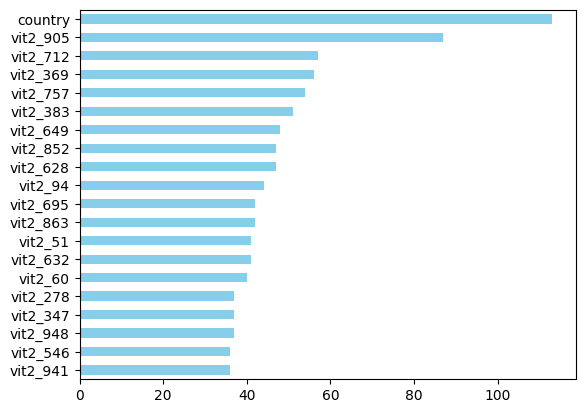

In [49]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')

top_features = importance_df.sort_values(ascending=False).head(20).sort_values()

# Plot the top features
top_features.plot.barh(color='skyblue')


### Image to text - embeddings

In [50]:
with open('data/features/output_embed_captions.json', 'r') as jfile:
    dict_features = json.load(jfile)

In [51]:
cap_features = pd.DataFrame(pd.Series(dict_features).rename('cap_array'))
cap_features.index.name = 'creative_id'
cap_features.reset_index(inplace=True)
cap_features_columns = [f'cap_{i}' for i in range(len(cap_features['cap_array'][0]))]
df_cap = pd.DataFrame(cap_features['cap_array'].tolist(), columns=cap_features_columns)

cap_features = pd.concat([cap_features, df_cap], axis=1)

cap_features.drop(columns=['cap_array'], inplace=True)
cap_features.creative_id = cap_features.creative_id.astype(int)
cap_features.head()

,creative_id,cap_0,cap_1,cap_2,cap_3,cap_4,cap_5,cap_6,cap_7,cap_8,...,cap_758,cap_759,cap_760,cap_761,cap_762,cap_763,cap_764,cap_765,cap_766,cap_767
0,6530,-0.022333,-0.038696,-0.101679,0.071254,0.028966,-0.029837,0.000091,0.024638,-0.064123,...,0.006072,-0.080577,0.029976,0.022809,0.044944,0.087174,-0.132366,0.098041,0.051489,0.049778
1,1935,0.112597,0.004799,-0.180030,0.016855,-0.110323,-0.078726,0.038380,0.091134,-0.056312,...,0.066037,0.028409,-0.064445,0.018046,0.039118,0.115481,-0.013722,0.015879,0.009497,0.081799
2,2965,0.076550,-0.053302,-0.162661,-0.003123,-0.077004,-0.082090,0.001749,0.065260,0.003042,...,0.106322,-0.051949,0.017465,0.067951,0.132236,0.060624,-0.015043,0.173507,0.111043,0.021062
3,2795,0.005605,0.052984,-0.043242,0.078549,-0.021410,-0.023727,0.026906,0.059497,0.080096,...,0.128398,-0.110454,-0.047293,0.144515,-0.021567,0.098259,-0.051132,0.111706,0.005780,0.000484
4,15195,0.093398,-0.032650,-0.150835,0.079075,-0.019503,-0.021055,-0.012013,0.151470,0.015061,...,0.072850,-0.035045,-0.009511,0.047048,0.035702,0.099220,0.032503,0.123980,0.046897,-0.051719


In [52]:
creative_data_cap = pd.merge(creative_data_vit2, cap_features, on='creative_id')
creative_data_cap.head()

,creative_id,no_of_days,impressions,clicks,media_cost_usd,campaign_counts,no_of_days_min,impressions_min,clicks_min,no_of_days_max,...,cap_758,cap_759,cap_760,cap_761,cap_762,cap_763,cap_764,cap_765,cap_766,cap_767
0,1000,45,9471,152,405.311290,5,7,837,8,11,...,-0.079931,-0.021899,0.104613,0.030679,0.086324,0.183646,-0.059469,0.004998,-0.079400,-0.024507
1,1005,5643,52011,638,805.049336,66,53,524,2,118,...,0.022289,-0.054080,0.014924,0.065613,0.059866,0.070172,-0.006224,0.134254,0.042897,0.104063
2,1010,5643,38026,519,405.672070,66,53,514,2,118,...,-0.013434,0.021966,0.037303,0.036310,0.167986,0.027211,-0.106756,0.026235,-0.068941,0.060003
3,1015,5643,48051,629,964.308318,66,53,546,2,118,...,-0.035637,-0.095447,-0.038050,0.011116,0.052608,0.141778,0.013437,0.022569,0.046896,0.010771
4,1020,5643,38519,512,414.202772,66,53,514,3,118,...,0.027301,0.079686,0.024962,0.042336,0.104204,0.154480,-0.026249,-0.008364,0.139246,-0.035463


In [53]:
train_data = creative_data_cap.loc[creative_ids_train].reset_index(drop=True)
test_data = creative_data_cap.loc[creative_ids_test].reset_index(drop=True)

In [54]:
features = [
   'country', 'aspect_ratio',
   #  'color', 'read_mean', 'green_mean', 'blue_mean',
   # 'red_std', 'green_std', 'blue_std', 'brightness', 'contrast', 'entropy',
   # 'warm_fraction', 'cool_fraction', 'saturation_mean', 'red_dom_color0',
   # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
   # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
   # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
   # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
   # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
   # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
   # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
   # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
   # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
   # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
   # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
   # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
   # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
features += cap_features_columns
target = 'effective'
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.79
ROC AUC: 0.52
Precision: 0.20
Recall: 0.056
F1 Score: 0.088


A slight improvement of the ROC but still not able to capture a useful relationship between the embeddings and the effectiveness category.

<Axes: >

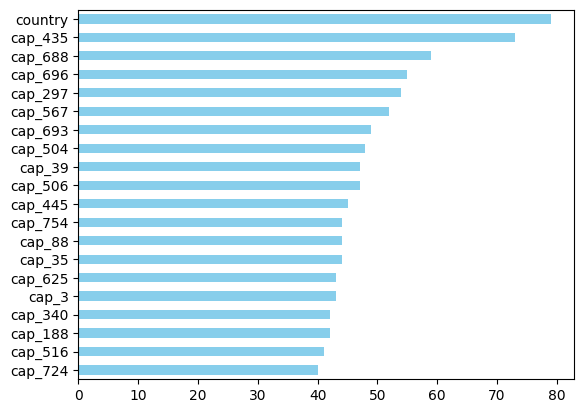

In [55]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')

top_features = importance_df.sort_values(ascending=False).head(20).sort_values()

top_features.plot.barh(color='skyblue')

In [57]:
cem = CreativeEffectivenessModel('nn2', features, target)
cem_error = cem.train_eval(train_data, test_data, verbose=False)
pd.Series(cem_error).round(3)

accuracy     0.715
roc_auc      0.528
precision    0.194
recall       0.178
f1           0.185
dtype: float64

Removing country and combining some pure statistical features of the images.

In [64]:
features = [
   # 'no_of_days', 'no_of_week_end',
   # 'Display_days', 'Mobile_days', 'Search_days', 'Social_days',
   # 'Video_days',
   #'country',
    # 'aspect_ratio',
    #  'color', 'read_mean', 'green_mean', 'blue_mean',
   # 'red_std', 'green_std', 'blue_std',
    # 'brightness', 'contrast', 'entropy',
    # 'warm_fraction', 'cool_fraction', 'saturation_mean',
   #  'red_dom_color0',
   # 'green_dom_color0', 'blue_dom_color0', 'weight_dom_color0',
   # 'red_dom_color1', 'green_dom_color1', 'blue_dom_color1',
   # 'weight_dom_color1', 'red_dom_color2', 'green_dom_color2',
   # 'blue_dom_color2', 'weight_dom_color2', 'red_dom_color3',
   # 'green_dom_color3', 'blue_dom_color3', 'weight_dom_color3',
   # 'red_dom_color4', 'green_dom_color4', 'blue_dom_color4',
   # 'weight_dom_color4', 'red_dom_color5', 'green_dom_color5',
   # 'blue_dom_color5', 'weight_dom_color5', 'red_dom_color6',
   # 'green_dom_color6', 'blue_dom_color6', 'weight_dom_color6',
   # 'red_dom_color7', 'green_dom_color7', 'blue_dom_color7',
   # 'weight_dom_color7', 'red_dom_color8', 'green_dom_color8',
   # 'blue_dom_color8', 'weight_dom_color8', 'red_dom_color9',
   # 'green_dom_color9', 'blue_dom_color9', 'weight_dom_color9'
    ]
#features += vit_features2_columns
features += cap_features_columns
target = 'effective'
cem = CreativeEffectivenessModel('lgbm', features, target)
cem_error = cem.train_eval(train_data, test_data)

Accuracy: 0.78
ROC AUC: 0.52
Precision: 0.23
Recall: 0.075
F1 Score: 0.113


<Axes: >

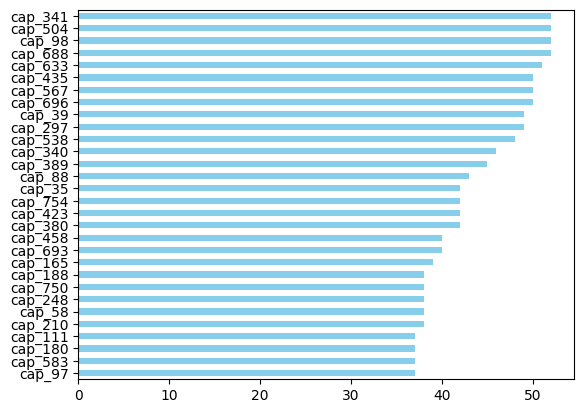

In [65]:
importance_df = pd.Series(index=features, data=cem.model.feature_importances_, name='feature importance')

top_features = importance_df.sort_values(ascending=False).head(30).sort_values()

top_features.plot.barh(color='skyblue')